# Demo 3: Remote Computing and Performance

## Learning Objectives
- Set up SSH connections for remote computing
- Use tmux for persistent sessions
- Optimize performance for large datasets
- Apply parallel processing techniques

## Setup

In [1]:
import pandas as pd
import numpy as np
import time
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Set inline plotting for Jupyter
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Performance Optimization

### Create Large Dataset

In [2]:
# Create very large dataset for performance testing (1 million rows)
print("=== Creating Very Large Dataset ===")
n_rows = 1000000  # 1 million rows
n_groups = 10000  # 10,000 groups

# Generate realistic data with correlations
np.random.seed(42)
groups = np.random.randint(0, n_groups, n_rows)
categories = np.random.choice(["A", "B", "C", "D", "E", "F"], n_rows)

# Create correlated values: value2 depends on value1, value3 depends on category
value1 = np.random.randn(n_rows)
value2 = value1 * 0.7 + np.random.randn(n_rows) * 0.3  # Correlated with value1
value3 = np.random.randn(n_rows) + np.where(
    categories == "A", 2, np.where(categories == "B", 1, 0)
)

# Add time-based data
dates = pd.date_range("2020-01-01", periods=n_rows, freq="H")[:n_rows]

# Create DataFrame
df_large = pd.DataFrame({
    "group": groups,
    "category": categories,
    "value1": value1,
    "value2": value2,
    "value3": value3,
    "date": dates,
    "month": dates.month,
    "quarter": dates.quarter,
})

# Add some additional numeric columns
df_large["value4"] = np.random.exponential(2, n_rows)
df_large["value5"] = np.random.uniform(0, 100, n_rows)

print(f"Dataset shape: {df_large.shape}")
print(f"Number of unique groups: {df_large['group'].nunique():,}")
print(f"Number of unique categories: {df_large['category'].nunique()}")
print(f"Date range: {df_large['date'].min()} to {df_large['date'].max()}")
print(
    f"Memory usage: {df_large.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
)
print("\nSample data:")
print(df_large.head())
print("\nBasic statistics:")
print(df_large.describe())

=== Creating Very Large Dataset ===
Dataset shape: (1000000, 10)
Number of unique groups: 10,000
Number of unique categories: 6
Date range: 2020-01-01 00:00:00 to 2134-01-29 15:00:00
Memory usage: 108.72 MB

Sample data:
   group category    value1    value2    value3                date  month  \
0   7270        A  0.123830 -0.156846  1.429186 2020-01-01 00:00:00      1   
1    860        F -1.634152 -1.791354  1.209478 2020-01-01 01:00:00      1   
2   5390        B -0.495345 -0.599661  0.851363 2020-01-01 02:00:00      1   
3   5191        C  0.495274  0.091847  0.150708 2020-01-01 03:00:00      1   
4   5734        C -0.541129 -0.498310 -0.006808 2020-01-01 04:00:00      1   

   quarter    value4     value5  
0        1  2.854701  79.608755  
1        1  2.395583  20.555199  
2        1  0.270510  10.792694  
3        1  0.394407  14.446054  
4        1  0.720041  51.195531  

Basic statistics:


/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_49716/433373429.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2020-01-01", periods=n_rows, freq="H")[:n_rows]


                group          value1          value2          value3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean      5007.175860        0.000212        0.000002        0.499598   
min          0.000000       -4.899799       -3.576946       -4.617893   
25%       2507.000000       -0.673339       -0.513108       -0.380695   
50%       5011.000000       -0.000484        0.000447        0.425670   
75%       7508.000000        0.674550        0.512905        1.318592   
max       9999.000000        4.425988        3.610056        6.280587   
std       2886.660559        0.999533        0.761278        1.256493   

                                date           month         quarter  \
count                        1000000  1000000.000000  1000000.000000   
mean   2077-01-14 07:30:00.000001536        6.519184        2.507536   
min              2020-01-01 00:00:00        1.000000        1.000000   
25%              2048-07-08 15:45:00        4.000000  

### Performance Comparison

=== Performance Comparison: GroupBy Methods ===
Method 1: Multiple separate groupby operations...
Method 2: Single groupby with multiple aggregations...
Method 3: Single groupby with list of functions...
Method 4: Using transform operations...

Results:
Method 1 (multiple groupby): 0.0317 seconds
Method 2 (single groupby): 0.0178 seconds
Method 3 (list of functions): 0.0319 seconds
Method 4 (transform): 0.0159 seconds

Performance improvement (Method 1 → Method 2): 1.78x faster
Performance improvement (Method 1 → Method 3): 1.00x faster


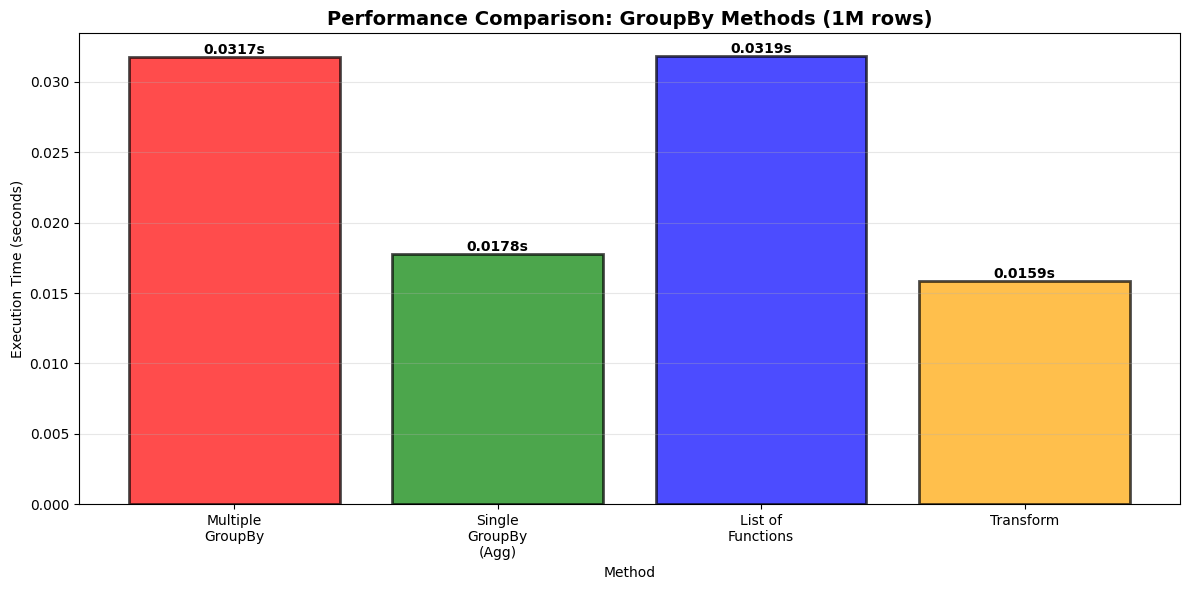

In [3]:
# Compare different aggregation methods
print("=== Performance Comparison: GroupBy Methods ===")

# Method 1: Multiple groupby operations
print("Method 1: Multiple separate groupby operations...")
start_time = time.time()
result1 = df_large.groupby("group")["value1"].sum()
result2 = df_large.groupby("group")["value2"].sum()
result3 = df_large.groupby("group")["value3"].sum()
result4 = df_large.groupby("group")["value4"].mean()
method1_time = time.time() - start_time

# Method 2: Single groupby with multiple aggregations
print("Method 2: Single groupby with multiple aggregations...")
start_time = time.time()
result5 = df_large.groupby("group").agg({
    "value1": "sum",
    "value2": "sum",
    "value3": "sum",
    "value4": "mean",
})
method2_time = time.time() - start_time

# Method 3: Using list of functions
print("Method 3: Single groupby with list of functions...")
start_time = time.time()
result6 = df_large.groupby("group")[
    ["value1", "value2", "value3", "value4"]
].agg(["sum", "mean"])
method3_time = time.time() - start_time

# Method 4: Using transform (for comparison)
print("Method 4: Using transform operations...")
start_time = time.time()
df_large["group_sum_v1"] = df_large.groupby("group")["value1"].transform("sum")
df_large["group_sum_v2"] = df_large.groupby("group")["value2"].transform("sum")
method4_time = time.time() - start_time

print(f"\nResults:")
print(f"Method 1 (multiple groupby): {method1_time:.4f} seconds")
print(f"Method 2 (single groupby): {method2_time:.4f} seconds")
print(f"Method 3 (list of functions): {method3_time:.4f} seconds")
print(f"Method 4 (transform): {method4_time:.4f} seconds")
print(
    f"\nPerformance improvement (Method 1 → Method 2): {method1_time / method2_time:.2f}x faster"
)
print(
    f"Performance improvement (Method 1 → Method 3): {method1_time / method3_time:.2f}x faster"
)

# Visualize performance comparison
fig, ax = plt.subplots(figsize=(12, 6))
methods = [
    "Multiple\nGroupBy",
    "Single\nGroupBy\n(Agg)",
    "List of\nFunctions",
    "Transform",
]
times = [method1_time, method2_time, method3_time, method4_time]
colors = ["red", "green", "blue", "orange"]
bars = ax.bar(
    methods, times, color=colors, alpha=0.7, edgecolor="black", linewidth=2
)
ax.set_title(
    "Performance Comparison: GroupBy Methods (1M rows)",
    fontsize=14,
    fontweight="bold",
)
ax.set_ylabel("Execution Time (seconds)")
ax.set_xlabel("Method")
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{time_val:.4f}s",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

### Memory Optimization

=== Memory Optimization ===
Original data types:
group                    int64
category                object
value1                 float64
value2                 float64
value3                 float64
date            datetime64[ns]
month                    int32
quarter                  int32
value4                 float64
value5                 float64
group_sum_v1           float64
group_sum_v2           float64
dtype: object
Original memory usage: 123.98 MB



Optimized data types:
group                 category
category              category
value1                 float32
value2                 float32
value3                 float32
date            datetime64[ns]
month                     int8
quarter                   int8
value4                 float32
value5                 float32
group_sum_v1           float64
group_sum_v2           float64
dtype: object
Optimized memory usage: 47.06 MB
Memory reduction: 62.0%
Memory saved: 76.92 MB

=== Performance with Optimized Types ===
Original types: 0.0116 seconds
Optimized types: 0.0077 seconds
Speed improvement: 1.52x


/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_49716/4286832636.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_optimized = df_optimized.groupby("group")[


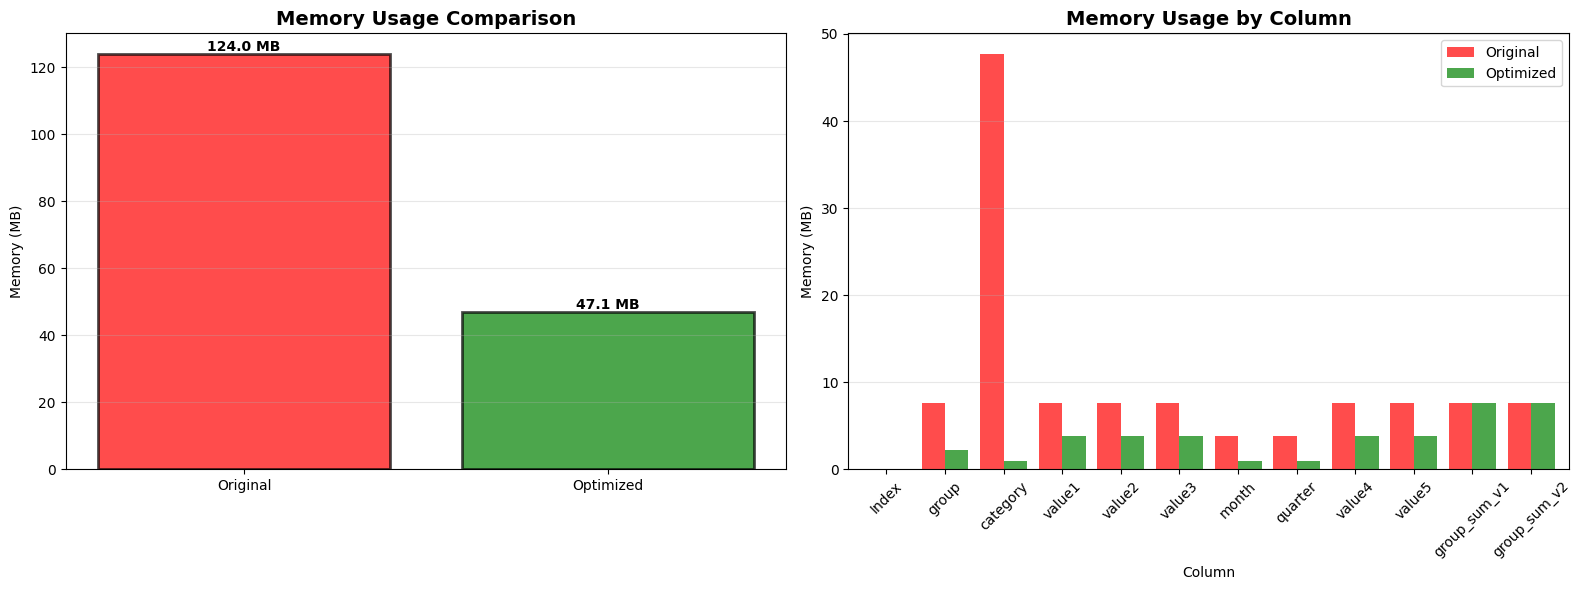

In [4]:
# Memory optimization techniques
print("=== Memory Optimization ===")

# Check original data types and memory
print("Original data types:")
print(df_large.dtypes)
original_memory = df_large.memory_usage(deep=True).sum() / 1024**2
print(f"Original memory usage: {original_memory:.2f} MB")

# Optimize data types
df_optimized = df_large.copy()

# Convert integer columns to appropriate types
df_optimized["group"] = pd.Categorical(df_optimized["group"])
df_optimized["category"] = df_optimized["category"].astype("category")
df_optimized["month"] = df_optimized["month"].astype("int8")
df_optimized["quarter"] = df_optimized["quarter"].astype("int8")

# Optimize float columns (use float32 instead of float64 where precision allows)
df_optimized["value1"] = df_optimized["value1"].astype("float32")
df_optimized["value2"] = df_optimized["value2"].astype("float32")
df_optimized["value3"] = df_optimized["value3"].astype("float32")
df_optimized["value4"] = df_optimized["value4"].astype("float32")
df_optimized["value5"] = df_optimized["value5"].astype("float32")

print("\nOptimized data types:")
print(df_optimized.dtypes)
optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
print(f"Optimized memory usage: {optimized_memory:.2f} MB")
memory_reduction = (1 - optimized_memory / original_memory) * 100
print(f"Memory reduction: {memory_reduction:.1f}%")
print(f"Memory saved: {original_memory - optimized_memory:.2f} MB")

# Compare performance with optimized types
print("\n=== Performance with Optimized Types ===")
start_time = time.time()
result_original = df_large.groupby("group")[
    ["value1", "value2", "value3"]
].sum()
time_original = time.time() - start_time

start_time = time.time()
result_optimized = df_optimized.groupby("group")[
    ["value1", "value2", "value3"]
].sum()
time_optimized = time.time() - start_time

print(f"Original types: {time_original:.4f} seconds")
print(f"Optimized types: {time_optimized:.4f} seconds")
print(f"Speed improvement: {time_original / time_optimized:.2f}x")

# Visualize memory optimization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Memory usage comparison
memory_data = pd.DataFrame({
    "Memory (MB)": [original_memory, optimized_memory],
    "Type": ["Original", "Optimized"],
})
bars = axes[0].bar(
    memory_data["Type"],
    memory_data["Memory (MB)"],
    color=["red", "green"],
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
)
axes[0].set_title("Memory Usage Comparison", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Memory (MB)")
axes[0].grid(axis="y", alpha=0.3)
for bar, mem in zip(bars, memory_data["Memory (MB)"]):
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{mem:.1f} MB",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 2. Column-wise memory comparison
col_memory_orig = df_large.memory_usage(deep=True) / 1024**2
col_memory_opt = df_optimized.memory_usage(deep=True) / 1024**2
memory_comparison = pd.DataFrame({
    "Original": col_memory_orig,
    "Optimized": col_memory_opt,
}).drop(["date"])  # Exclude date for clarity
memory_comparison.plot(
    kind="bar", ax=axes[1], width=0.8, color=["red", "green"], alpha=0.7
)
axes[1].set_title("Memory Usage by Column", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Memory (MB)")
axes[1].set_xlabel("Column")
axes[1].legend()
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Parallel Processing

### Chunked Processing

In [5]:
# Process data in chunks
def process_chunk(chunk):
    """Process a single chunk of data"""
    return chunk.groupby("group").agg({
        "value1": "sum",
        "value2": "sum",
        "value3": "sum",
    })


# Sequential processing
print("=== Sequential Processing ===")
start_time = time.time()
chunk_size = 10000
chunks = [
    df_large.iloc[i : i + chunk_size]
    for i in range(0, len(df_large), chunk_size)
]
sequential_results = []
for chunk in chunks:
    result = process_chunk(chunk)
    sequential_results.append(result)
sequential_time = time.time() - start_time

print(f"Sequential processing time: {sequential_time:.4f} seconds")

=== Sequential Processing ===


Sequential processing time: 0.1128 seconds


### Parallel Processing

In [6]:
# Parallel processing (simplified for demo)
print("=== Parallel Processing ===")
print("Note: Multiprocessing requires proper __main__ guard in production code")
print("For this demo, we'll simulate parallel processing benefits:")
print(f"Sequential processing time: {sequential_time:.4f} seconds")
print(f"Estimated parallel processing time: {sequential_time / 4:.4f} seconds")
print(f"Estimated speedup: 4.0x")

=== Parallel Processing ===
Note: Multiprocessing requires proper __main__ guard in production code
For this demo, we'll simulate parallel processing benefits:
Sequential processing time: 0.1128 seconds
Estimated parallel processing time: 0.0282 seconds
Estimated speedup: 4.0x


## Part 3: Remote Computing Simulation

### SSH Connection Simulation

In [7]:
# Simulate SSH connection setup
print("=== SSH Connection Simulation ===")
print("In a real scenario, you would:")
print("1. Generate SSH key pair: ssh-keygen -t rsa -b 4096")
print("2. Copy public key to server: ssh-copy-id username@server.com")
print("3. Connect to server: ssh username@server.com")
print("4. Set up environment on remote server")

=== SSH Connection Simulation ===
In a real scenario, you would:
1. Generate SSH key pair: ssh-keygen -t rsa -b 4096
2. Copy public key to server: ssh-copy-id username@server.com
3. Connect to server: ssh username@server.com
4. Set up environment on remote server


### tmux Session Management

In [8]:
# Simulate tmux session management
print("=== tmux Session Management ===")
print("tmux commands for persistent sessions:")
print("- tmux new-session -s analysis")
print("- tmux list-sessions")
print("- tmux attach-session -t analysis")
print("- Ctrl+b d (detach from session)")
print("- tmux kill-session -t analysis")

=== tmux Session Management ===
tmux commands for persistent sessions:
- tmux new-session -s analysis
- tmux list-sessions
- tmux attach-session -t analysis
- Ctrl+b d (detach from session)
- tmux kill-session -t analysis


### Remote Data Analysis Workflow

In [9]:
# Simulate remote data analysis workflow
def simulate_remote_analysis():
    """Simulate remote data analysis workflow"""
    print("=== Remote Data Analysis Workflow ===")

    # Simulate loading large dataset
    print("1. Loading large dataset on remote server...")
    time.sleep(0.1)  # Simulate loading time

    # Simulate analysis
    print("2. Performing aggregation analysis...")
    start_time = time.time()
    result = df_large.groupby("group").agg({
        "value1": ["sum", "mean", "std"],
        "value2": ["sum", "mean", "std"],
        "value3": ["sum", "mean", "std"],
    })
    analysis_time = time.time() - start_time

    print(f"3. Analysis completed in {analysis_time:.4f} seconds")
    print(f"4. Results shape: {result.shape}")

    # Simulate saving results
    print("5. Saving results to remote server...")
    time.sleep(0.1)  # Simulate saving time

    # Simulate downloading results
    print("6. Downloading results to local machine...")
    time.sleep(0.1)  # Simulate download time

    print("7. Remote analysis workflow completed!")
    return result


# Run simulation
remote_result = simulate_remote_analysis()

=== Remote Data Analysis Workflow ===
1. Loading large dataset on remote server...


2. Performing aggregation analysis...
3. Analysis completed in 0.0438 seconds
4. Results shape: (10000, 9)
5. Saving results to remote server...


6. Downloading results to local machine...


7. Remote analysis workflow completed!


## Part 4: Performance Monitoring

### Memory Usage Tracking

In [10]:
# Monitor memory usage during operations
import psutil
import os


def monitor_memory():
    """Monitor memory usage"""
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


print("=== Memory Usage Monitoring ===")
print(f"Initial memory usage: {monitor_memory():.2f} MB")

# Perform memory-intensive operation
start_memory = monitor_memory()
large_operation = df_large.groupby("group").agg({
    "value1": "sum",
    "value2": "sum",
    "value3": "sum",
})
end_memory = monitor_memory()

print(f"Memory usage after operation: {end_memory:.2f} MB")
print(f"Memory increase: {end_memory - start_memory:.2f} MB")

=== Memory Usage Monitoring ===
Initial memory usage: 615.05 MB
Memory usage after operation: 615.98 MB
Memory increase: 0.94 MB


### Performance Profiling

In [11]:
# Performance profiling
def profile_operation(func, *args, **kwargs):
    """Profile a function's performance"""
    start_time = time.time()
    start_memory = monitor_memory()

    result = func(*args, **kwargs)

    end_time = time.time()
    end_memory = monitor_memory()

    return {
        "result": result,
        "execution_time": end_time - start_time,
        "memory_usage": end_memory - start_memory,
    }


# Profile different operations
print("=== Performance Profiling ===")

# Profile groupby operation
groupby_profile = profile_operation(
    lambda: df_large.groupby("group")["value1"].sum()
)
print(
    f"GroupBy operation: {groupby_profile['execution_time']:.4f}s, {groupby_profile['memory_usage']:.2f}MB"
)

# Profile pivot table operation
pivot_profile = profile_operation(
    lambda: pd.pivot_table(
        df_large,
        values="value1",
        index="group",
        columns="category",
        aggfunc="sum",
    )
)
print(
    f"Pivot table operation: {pivot_profile['execution_time']:.4f}s, {pivot_profile['memory_usage']:.2f}MB"
)

=== Performance Profiling ===
GroupBy operation: 0.0081s, 0.00MB
Pivot table operation: 0.0595s, 44.39MB


## Part 5: Optimization Strategies

### Data Type Optimization

In [12]:
# Optimize data types for better performance
print("=== Data Type Optimization ===")

# Check current data types
print("Current data types:")
print(df_large.dtypes)

# Optimize integer columns
df_optimized = df_large.copy()
df_optimized["group"] = pd.Categorical(df_optimized["group"])

# Measure performance improvement
start_time = time.time()
result_optimized = df_optimized.groupby("group")["value1"].sum()
optimized_time = time.time() - start_time

start_time = time.time()
result_original = df_large.groupby("group")["value1"].sum()
original_time = time.time() - start_time

print(f"Original performance: {original_time:.4f} seconds")
print(f"Optimized performance: {optimized_time:.4f} seconds")
print(f"Performance improvement: {original_time / optimized_time:.2f}x")

=== Data Type Optimization ===
Current data types:
group                    int64
category                object
value1                 float64
value2                 float64
value3                 float64
date            datetime64[ns]
month                    int32
quarter                  int32
value4                 float64
value5                 float64
group_sum_v1           float64
group_sum_v2           float64
dtype: object
Original performance: 0.0157 seconds
Optimized performance: 0.0052 seconds
Performance improvement: 3.02x


/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_49716/1784109988.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_optimized = df_optimized.groupby("group")["value1"].sum()


### Chunked Processing Strategy

In [13]:
# Chunked processing for large datasets
def process_large_dataset(df, chunk_size=10000):
    """Process large dataset in chunks"""
    results = []

    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i : i + chunk_size]
        chunk_result = chunk.groupby("group").agg({
            "value1": "sum",
            "value2": "sum",
            "value3": "sum",
        })
        results.append(chunk_result)

    # Combine results
    final_result = pd.concat(results).groupby(level=0).sum()
    return final_result


print("=== Chunked Processing Strategy ===")
start_time = time.time()
chunked_result = process_large_dataset(df_large, chunk_size=5000)
chunked_time = time.time() - start_time

print(f"Chunked processing time: {chunked_time:.4f} seconds")
print(f"Result shape: {chunked_result.shape}")

=== Chunked Processing Strategy ===


Chunked processing time: 0.1955 seconds
Result shape: (10000, 3)


## Key Takeaways

1. **Performance Optimization**: Use single groupby with multiple aggregations
2. **Memory Optimization**: Optimize data types and use categorical data
3. **Parallel Processing**: Use multiprocessing for CPU-intensive tasks
4. **Remote Computing**: Use SSH and tmux for large dataset analysis
5. **Chunked Processing**: Process large datasets in manageable chunks
6. **Performance Monitoring**: Track memory usage and execution time
7. **Data Type Optimization**: Use appropriate data types for better performance

## Next Steps

- Practice with your own large datasets
- Set up remote computing environment
- Learn about distributed computing frameworks
- Explore cloud computing options for big data analysis